step 0

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.nn import Conv2d, LeakyReLU, MaxPool2d, Flatten, Linear, Dropout, Upsample, ReLU, ConvTranspose2d, Tanh, BatchNorm2d
from torchsummary import summary # type: ignore
import torch.nn.functional as F

In [2]:
class GeneratorModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = Conv2d(1, 64, kernel_size=4, stride=2)
        self.db1 = nn.Sequential(
            LeakyReLU(),
            Conv2d(64, 128, kernel_size=4, stride=2),
            BatchNorm2d(128)
        )
        self.db2 = nn.Sequential(
            LeakyReLU(),
            Conv2d(128, 1256, kernel_size=4, stride=2),
            BatchNorm2d(1256)
        )
        self.db3 = nn.Sequential(
            LeakyReLU(),
            Conv2d(1256, 512, kernel_size=4, stride=2),
            BatchNorm2d(512)
        )
        self.db4 = nn.Sequential(
            LeakyReLU(),
            Conv2d(512, 512, kernel_size=4, stride=2),
            BatchNorm2d(512)
        ) ## same as db 5 and db6
        self.db5 = nn.Sequential(
            LeakyReLU(),
            Conv2d(512, 512, kernel_size=4, stride=2),
            BatchNorm2d(512)
        )
        self.db6 = nn.Sequential(
            LeakyReLU(),
            Conv2d(512, 512, kernel_size=4, stride=2),
            BatchNorm2d(512)
        )
        self.dl = nn.Sequential(
            LeakyReLU(),
            Conv2d(512, 512, kernel_size=4, stride=2),
        )

        self.uf = nn.Sequential(
            ReLU(),
            ConvTranspose2d(512, 512, kernel_size=4, stride=2),
            BatchNorm2d(512)
        )
        self.ub1 = nn.Sequential(
            ReLU(),
            ConvTranspose2d(512, 512, kernel_size=4, stride=2),
            BatchNorm2d(512)
        ) ## same as ub2 and ub3
        self.ub2 = nn.Sequential(
            ReLU(),
            ConvTranspose2d(512, 512, kernel_size=4, stride=2),
            BatchNorm2d(512)
        )
        self.ub3 = nn.Sequential(
            ReLU(),
            ConvTranspose2d(512, 512, kernel_size=4, stride=2),
            BatchNorm2d(512)
        )
        self.ub4 = nn.Sequential(
            ReLU(),
            ConvTranspose2d(512, 256, kernel_size=4, stride=2),
            BatchNorm2d(256)
        )
        self.ub5 = nn.Sequential(
            ReLU(),
            ConvTranspose2d(256, 128, kernel_size=4, stride=2),
            BatchNorm2d(128)
        )

        self.ub6 = nn.Sequential(
            ReLU(),
            ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            BatchNorm2d(64)
        )
        self.ul = nn.Sequential(
            ReLU(),
            ConvTranspose2d(64, 3, kernel_size=4, stride=2),
            Tanh()
        )

    def forward(self, x):
        c1 = self.conv1(x)
        d1 = self.db1(c1)
        d2 = self.db2(d1)
        d3 = self.db3(d2)
        d4 = self.db4(d3)
        d5 = self.db5(d4)
        d6 = self.db6(d5)
        l = self.dl(d6)       # g = self.generator(l)
        f = self.uf(l)
        
        conv = Conv2d(1024, 512, kernel_size=1).to(device=device)

        u1 = self.ub1(conv(torch.cat([f, d6], dim=1)))
        u2 = self.ub2(conv(torch.concat([u1, d5], dim=1)))
        u3 = self.ub3(conv(torch.concat([u2, d4], dim=1)))
        u4 = self.ub4(conv(torch.concat([u3, d3], dim=1)))

        conv2 = Conv2d(1512, 256, kernel_size=1).to(device=device)

        u5 = self.ub5(conv2(torch.concat([u4, d2], dim=1)))

        conv3 = Conv2d(256, 128, kernel_size=1).to(device=device)

        u6 = self.ub6(conv3(torch.concat([u5, d1], dim=1)))

        c1_cropped = c1[:, :, :510, :510]
        conv4 = Conv2d(128, 64, kernel_size=1).to(device=device)
        u7 = self.ul(conv4(torch.concat([u6, c1_cropped], dim=1)))
        return u7



device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GeneratorModel().to(device=device)
# print(summary(model, (1, 1024, 1024)))
print(summary(model, (1, 1024, 1024)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 511, 511]           1,088
         LeakyReLU-2         [-1, 64, 511, 511]               0
            Conv2d-3        [-1, 128, 254, 254]         131,200
       BatchNorm2d-4        [-1, 128, 254, 254]             256
         LeakyReLU-5        [-1, 128, 254, 254]               0
            Conv2d-6       [-1, 1256, 126, 126]       2,573,544
       BatchNorm2d-7       [-1, 1256, 126, 126]           2,512
         LeakyReLU-8       [-1, 1256, 126, 126]               0
            Conv2d-9          [-1, 512, 62, 62]      10,289,664
      BatchNorm2d-10          [-1, 512, 62, 62]           1,024
        LeakyReLU-11          [-1, 512, 62, 62]               0
           Conv2d-12          [-1, 512, 30, 30]       4,194,816
      BatchNorm2d-13          [-1, 512, 30, 30]           1,024
        LeakyReLU-14          [-1, 512,

In [3]:
class DiscriminatorModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.bl0 = nn.Sequential(
            Conv2d(4, 64, kernel_size=4, stride=2),
            LeakyReLU(),
        )
        self.bl1 = nn.Sequential(
            Conv2d(64, 128, kernel_size=4, stride=2),
            BatchNorm2d(128),
            LeakyReLU()
        )
        self.bl2 = nn.Sequential(
            Conv2d(128, 256, kernel_size=4, stride=2),
            BatchNorm2d(256),
            LeakyReLU()
        )
        self.bl3 = nn.Sequential(
            Conv2d(256, 512, kernel_size=4, stride=2),
            BatchNorm2d(512),
            LeakyReLU()
        )

        self.conv = Conv2d(512, 1, kernel_size=4, stride=2)
        
    def forward(self, SAR, cSAR):
        x = torch.cat([SAR, cSAR], dim=1)
        x = self.bl0(x)
        x = self.bl1(x)
        x = self.bl2(x)
        x = self.bl3(x)
        x = self.conv(x)
        return x






In [4]:
class SARModel():
    def __init__(self):
        self.generator = GeneratorModel().to(device=device)
        self.discriminator = DiscriminatorModel().to(device=device)
        #self.writer = SummaryWriter('runs/sar')

    def train(self, train_dataloader:DataLoader, test_dataloader:DataLoader, epochs:int = 10):
        pass


if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    g_model = GeneratorModel().to(device=device)
    # print(summary(model, (1, 1024, 1024)))
    # print(summary(g_model, (1, 1024, 1024)))
    # print(g_model(torch.randn(1, 1, 1024, 1024).to(device=device)))

    d_model = DiscriminatorModel().to(device=device)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

class SARModel():
    def __init__(self):
        self.generator = GeneratorModel().to(device=device)
        self.discriminator = DiscriminatorModel().to(device=device)
        self.writer = SummaryWriter('runs/sar')

        # Define optimizers
        self.gen_optimizer = optim.Adam(self.generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
        self.disc_optimizer = optim.Adam(self.discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

        # Define loss function
        self.criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss

    def train(self, train_dataloader:DataLoader, test_dataloader:DataLoader, epochs:int = 10):
        # Fixed labels for real and fake images
        real_label = 1.0
        fake_label = 0.0

        for epoch in tqdm(range(epochs)):
            epoch_gen_loss = 0.0
            epoch_disc_loss = 0.0

            for i, (grayscale_imgs, rgb_imgs) in enumerate(tqdm(train_dataloader)):
                # Debugging: Print tensor shapes
                print(f"Grayscale image shape: {grayscale_imgs.shape}")
                print(f"RGB image shape: {rgb_imgs.shape}")

                # Move tensors to GPU
                grayscale_imgs = grayscale_imgs.to(device)
                rgb_imgs = rgb_imgs.to(device)

                # Discriminator Training
                self.discriminator.zero_grad()

                # Real images
                output_real = self.discriminator(grayscale_imgs, rgb_imgs).view(-1)
                print(f"Discriminator output (real): {output_real.shape}")
                real_loss = self.criterion(output_real, torch.full_like(output_real, real_label, dtype=torch.float, device=device))
                
                # Fake images
                fake_imgs = self.generator(grayscale_imgs)
                output_fake = self.discriminator(grayscale_imgs, fake_imgs.detach()).view(-1)
                print(f"Discriminator output (fake): {output_fake.shape}")
                fake_loss = self.criterion(output_fake, torch.full_like(output_fake, fake_label, dtype=torch.float, device=device))
                
                # Total discriminator loss
                disc_loss = real_loss + fake_loss
                disc_loss.backward()
                self.disc_optimizer.step()

                # Generator Training
                self.generator.zero_grad()

                output_fake_for_gen = self.discriminator(grayscale_imgs, fake_imgs).view(-1)
                gen_loss = self.criterion(output_fake_for_gen, torch.full_like(output_fake_for_gen, real_label, dtype=torch.float, device=device))
                gen_loss.backward()
                self.gen_optimizer.step()

                # Accumulate losses for logging
                epoch_gen_loss += gen_loss.item()
                epoch_disc_loss += disc_loss.item()

            # Log the average loss over the epoch
            self.writer.add_scalar('Generator Loss', epoch_gen_loss / len(train_dataloader), epoch)
            self.writer.add_scalar('Discriminator Loss', epoch_disc_loss / len(train_dataloader), epoch)
            
            print(f"Epoch [{epoch + 1}/{epochs}] | Gen Loss: {epoch_gen_loss / len(train_dataloader):.4f} | Disc Loss: {epoch_disc_loss / len(train_dataloader):.4f}")


In [6]:
from torch.utils.data import DataLoader, Dataset
import os
from pathlib import Path
from skimage import io
import random

basedir = Path('C:\ml\sanji\sih\Sar_Colorization\ROIs2017_winter_s2')
imagepath = list(basedir.glob('*/*.tif'))

train_paths = random.sample(imagepath, 500)
test_path = random.sample([img for img in imagepath if img not in train_paths], 100)
print(len(train_paths), len(test_path))

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Ruchir Kalokhe\AppData\Local\Temp\ipykernel_15132\3321347892.py:7: SyntaxWarning: invalid escape sequence '\m'
  basedir = Path('C:\ml\sanji\sih\Sar_Colorization\ROIs2017_winter_s2')
C:\Users\Ruchir Kalokhe\AppData\Local\Temp\ipykernel_15132\3321347892.py:7: SyntaxWarning: invalid escape sequence '\m'
  basedir = Path('C:\ml\sanji\sih\Sar_Colorization\ROIs2017_winter_s2')


ValueError: Sample larger than population or is negative

In [ ]:
test_path

NameError: name 'test_path' is not defined

In [ ]:
import numpy as np
class create_dataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = io.imread(self.image_paths[idx])
            # Normalize the image to 0-1 range for each channel
        img_normalized = (img - img.min()) / (img.max() - img.min())

        # Create a pseudo-color image
        pseudo_color = np.stack([
            img_normalized[:,:,3],  # Red channel
            img_normalized[:,:,2],  # Green channel
            img_normalized[:,:,1] # img_normalized[:,:,1]) / 2  # Blue channel (average of the two)
        ], axis=-1)
        img = np.mean(pseudo_color, axis=2)
        img = torch.tensor(img, dtype=torch.float).unsqueeze(0)
        pseudo_color = torch.tensor(pseudo_color, dtype=torch.float).permute(2, 0, 1)
        return img, pseudo_color

In [ ]:
train_dataset = create_dataset(train_paths)
test_dataset = create_dataset(test_path)

NameError: name 'train_paths' is not defined

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
next(iter(train_dataset))

NameError: name 'train_dataset' is not defined

In [ ]:
x,y = next(iter(train_dataset))
x.shape, y.shape

(torch.Size([1, 256, 256]), torch.Size([3, 256, 256]))

In [ ]:
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\ml\\sanji\\sih\\Sar_Colorization\\ROIs2017_winter_s2\\s2_116\\ROIs2017_winter_s2_116_p595.tif'

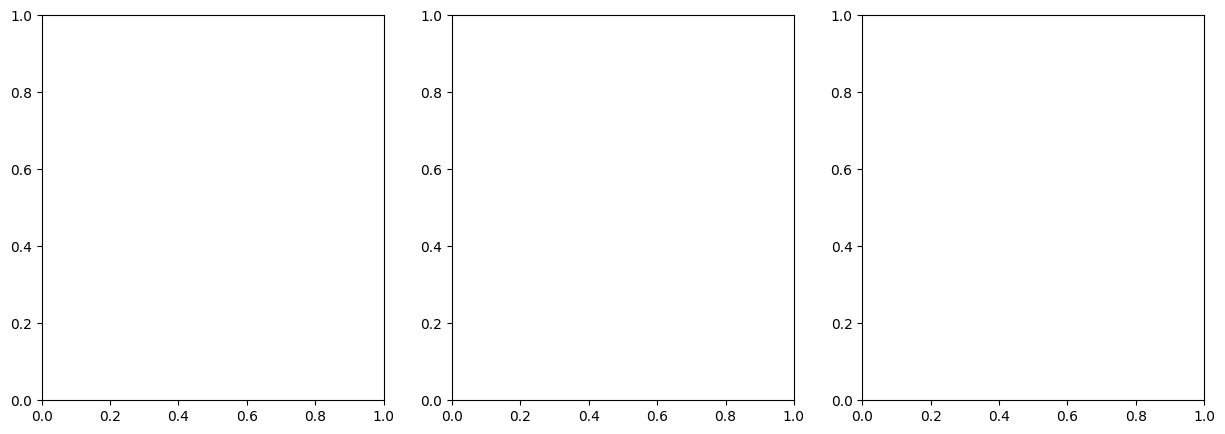

In [7]:
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# List of image file paths (p125 to p128)
image_files = [
    Path(r'C:\ml\sanji\sih\Sar_Colorization\ROIs2017_winter_s2\s2_116\ROIs2017_winter_s2_116_p595.tif'),
    Path(r'C:\ml\sanji\sih\Sar_Colorization\ROIs2017_winter_s2\s2_116\ROIs2017_winter_s2_116_p596.tif'),
    Path(r'C:\ml\sanji\sih\Sar_Colorization\ROIs2017_winter_s2\s2_116\ROIs2017_winter_s2_116_p597.tif'),
    # Path('E:\\Projects\\SAR colorization\\ROIs2017_winter_s1\\s1_116\\ROIs2017_winter_s1_116_p128.tif')
]

# Create a 3x3 grid
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each image file and place it in the grid
for idx, img_file in enumerate(image_files):
    # Read the image stack
    img = io.imread(img_file)
    print(f"Original shape: {img.shape}")

    # Normalize the image to 0-1 range for each channel
    img_normalized = (img - img.min()) / (img.max() - img.min())

    # Create a pseudo-color image
    pseudo_color = np.stack([
        img_normalized[:,:,3],  # Red channel
        img_normalized[:,:,2],  # Green channel
        img_normalized[:,:,1] # img_normalized[:,:,1]) / 2  # Blue channel (average of the two)
    ], axis=-1)

    # Display the pseudo-color image
    axes[idx].imshow(pseudo_color)
    axes[idx].set_title(img_file.name)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model = SARModel()
model.train(train_dataloader, test_dataloader, epochs=10)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
import torch
print(torch.__version__)

2.4.0+cu124


In [9]:
!nvidia-smi

Sun Sep  1 11:00:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              2W /   80W |    2967MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name()}")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


# RESTARTING

## DATA PIPELINE

### Segmentation

In [2]:
!pip install opencv-python

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.8 MB ? eta -:--:--
    --------------------------------------- 0.5/38.8 MB 1.9 MB/s eta 0:00:21
    --------------------------------------- 0.8/38.8 MB 1.8 MB/s eta 0:00:22
   - -------------------------------------- 1.0/38.8 MB 1.7 MB/s eta 0:00:22
   - -------------------------------------- 1.0/38.8 MB 1.7 MB/s eta 0:00:22
   - -------------------------------------- 1.3/38.8 MB 1.2 MB/s eta 0:00:32
   - -------------------------------------- 1.3/38.8 MB 1.2 MB/s eta 0:00:32
   - -------------------------------------- 1.6/38.8 MB 921.7 kB/s eta 0:00:41
   - -------------------------------------- 1.8/38.8 MB 1.0 MB/s eta 0:00:37
   -- ------------------------------------- 2.6/38.8 MB 1.3 MB/s eta 0:00:28
   --- ------------------------------------ 3.1/38.8 MB 1.5 MB/s eta 0:00:25
   ---- ----------------------------------- 3.9/38.8 MB 1.7 MB/s eta 0:00:22
   ---- ---

In [9]:
import cv2
import numpy as np

# Original SAR Image Dimensions
width = 2500
height = 1733

# Tile Dimensions (approx. 10% of original)
tile_width = int(width / 4)
tile_height = int(height / 4)

def segment_image(image):
    # Create a grid of coordinates to divide the image into tiles
    x_coords = np.arange(0, width + tile_width - 1, tile_width)
    y_coords = np.arange(0, height + tile_height - 1, tile_height)

    # Initialize an empty list to store the segmented tiles
    segments = []

    for i in range(len(x_coords) - 1):
        x1 = x_coords[i]
        x2 = x_coords[i + 1]

        for j in range(len(y_coords) - 1):
            y1 = y_coords[j]
            y2 = y_coords[j + 1]

            # Extract the tile from the original image
            segment = image[y1:y2, x1:x2]

            # Store the extracted tile in the segments list
            segments.append(segment)

    return segments

# Load the SAR Image (for demonstration purposes only)
sar_image_path = "SAR_Image_Colorization_Pairs/train/SAR-Image-1.jpg"
image = cv2.imread(sar_image_path)

# Segment the SAR image into 500x373 tiles
segments = segment_image(image)

print(f"Number of segmented tiles: {len(segments)}")

# Save each tile to a separate file (optional)
for i, segment in enumerate(segments):
    cv2.imwrite(f"tile_{i}.jpg", segment)


Number of segmented tiles: 16
